In [282]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
# tqdm allows you to see the process for each iteration 
from tqdm.auto import tqdm
%matplotlib inline

In [283]:
import warnings
warnings.filterwarnings("ignore")

In [284]:
data=pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

In [285]:
data.shape

(11914, 16)

In [286]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [287]:
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [288]:
features = [
    'Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
    'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP'
]

In [289]:
data=data[features]

In [290]:
data=data.rename(columns={'MSRP':'price'})
data.columns=data.columns.str.lower().str.replace(' ','_')

In [291]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11845 non-null  float64
 4   engine_cylinders   11884 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   price              11914 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 930.9+ KB


In [292]:
data.nunique()

make                   48
model                 915
year                   28
engine_hp             356
engine_cylinders        9
transmission_type       5
vehicle_style          16
highway_mpg            59
city_mpg               69
price                6049
dtype: int64

In [293]:
data.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
price                 0
dtype: int64

In [294]:
data['engine_hp']=data['engine_hp'].fillna(0)
data['engine_cylinders']=data['engine_cylinders'].fillna(0)

In [295]:
data.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
price                0
dtype: int64

In [296]:
data.describe(include='O')

,make,model,transmission_type,vehicle_style
count,11914,11914,11914,11914
unique,48,915,5,16
top,Chevrolet,Silverado 1500,AUTOMATIC,Sedan
freq,1123,156,8266,3048


In [297]:
data['transmission_type'].value_counts()

AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: transmission_type, dtype: int64

In [298]:
data_numeric = data.copy()
data_numeric=data.drop(['make','model','transmission_type','vehicle_style','price'],axis=1)
data_numeric.describe()

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg
count,11914.000000,11914.000000,11914.000000,11914.000000,11914.000000
mean,2010.384338,247.941749,5.614655,26.637485,19.733255
std,7.579740,110.507669,1.800554,8.863001,8.987798
min,1990.000000,0.000000,0.000000,12.000000,7.000000
25%,2007.000000,170.000000,4.000000,22.000000,16.000000
50%,2015.000000,225.000000,6.000000,26.000000,18.000000
75%,2016.000000,300.000000,6.000000,30.000000,22.000000
max,2017.000000,1001.000000,16.000000,354.000000,137.000000


In [299]:
data_numeric.corr()

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg
year,1.000000,0.338714,-0.040708,0.258240,0.198171
engine_hp,0.338714,1.000000,0.774851,-0.415707,-0.424918
engine_cylinders,-0.040708,0.774851,1.000000,-0.614541,-0.587306
highway_mpg,0.258240,-0.415707,-0.614541,1.000000,0.886829
city_mpg,0.198171,-0.424918,-0.587306,0.886829,1.000000


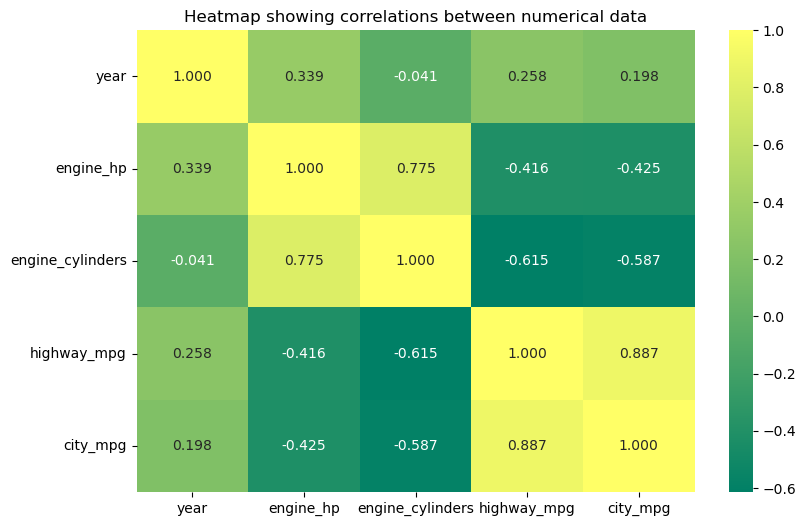

In [300]:
plt.figure(figsize=(9, 6))
sns.heatmap(data_numeric.corr(), cmap="summer", annot=True, fmt='.3f')
plt.title('Heatmap showing correlations between numerical data')
plt.show();

In [301]:
data_numeric.corr().unstack().sort_values(ascending = False)

year              year                1.000000
engine_hp         engine_hp           1.000000
highway_mpg       highway_mpg         1.000000
engine_cylinders  engine_cylinders    1.000000
city_mpg          city_mpg            1.000000
                  highway_mpg         0.886829
highway_mpg       city_mpg            0.886829
engine_hp         engine_cylinders    0.774851
engine_cylinders  engine_hp           0.774851
engine_hp         year                0.338714
year              engine_hp           0.338714
                  highway_mpg         0.258240
highway_mpg       year                0.258240
city_mpg          year                0.198171
year              city_mpg            0.198171
                  engine_cylinders   -0.040708
engine_cylinders  year               -0.040708
highway_mpg       engine_hp          -0.415707
engine_hp         highway_mpg        -0.415707
                  city_mpg           -0.424918
city_mpg          engine_hp          -0.424918
             

In [302]:
data['price'].mean()

40594.737032063116

In [303]:
data_class = data.copy()
mean = data_class['price'].mean()
data_class['above_average'] = np.where(data_class['price']>=mean,1,0)

In [304]:
data_class

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0
...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,46120,1
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,56670,1
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50620,1
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50920,1


In [305]:
data_class = data_class.drop(['price'], axis=1)

In [306]:
data_class

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0
...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,1
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,1
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,1
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,1


In [307]:
SEED = 1

In [308]:
df_full_train, df_test = train_test_split(data_class, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

assert len(data_class) == (len(df_train) + len(df_val) + len(df_test))

In [309]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [310]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [311]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

In [312]:
def calculate_mi(series):
    return mutual_info_score(series, df_train.above_average)

In [313]:
cat = ['make', 'model', 'transmission_type', 'vehicle_style']

In [314]:
df_mi = df_train[cat].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
model,0.465827
make,0.240793
vehicle_style,0.084477
transmission_type,0.019550


In [315]:
df_train = df_train.drop('above_average', axis=1)
df_val = df_val.drop('above_average', axis=1)
df_test = df_test.drop('above_average', axis=1)

assert 'above_average' not in df_train.columns
assert 'above_average' not in df_val.columns
assert 'above_average' not in df_test.columns

### Question 1: ROC AUC feature importance

In [316]:
numerical=list(data_numeric.columns)

In [317]:
numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [318]:
#@ CALCULATING ROC AUC SCORE:
feature_score={}
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
        feature_score[c]=auc
    feature_score[c]=auc
    print('%9s, %.3f' % (c, auc))
print()    
max_key = max(feature_score, key=lambda k: feature_score[k])
max_value = feature_score[max_key]
print('Maximum feature and value: %9s, %.3f' % (max_key,max_value))

     year, 0.688
engine_hp, 0.917
engine_cylinders, 0.766
highway_mpg, 0.633
 city_mpg, 0.673

Maximum feature and value: engine_hp, 0.917


### Question 2: Training the model

In [319]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [320]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000,random_state=SEED)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [332]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [333]:
#@ INSPECTING ROC AUC SCORE:
roc_auc_score(y_val, y_pred>=0.5).round(3)

0.912

In [334]:

#@ INSPECTING THE ROC AUC SCORE:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.9115082165540882

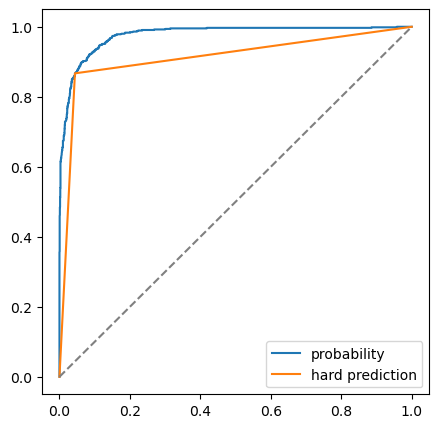

In [335]:

#@ INSPECTING THE ROC CURVE:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

### Question 3: Precision and Recall

In [336]:
#@ CREATING CONFUSION MATRIX:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


#@ IMPLEMENTATION OF FUNCTION:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,643,345,11,1384
20,0.2,622,218,32,1511
30,0.3,606,159,48,1570
40,0.4,588,109,66,1620
50,0.5,567,76,87,1653
60,0.6,522,49,132,1680
70,0.7,490,36,164,1693
80,0.8,440,17,214,1712
90,0.9,347,4,307,1725


In [337]:
#@ ADDING THE COLUMNS:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

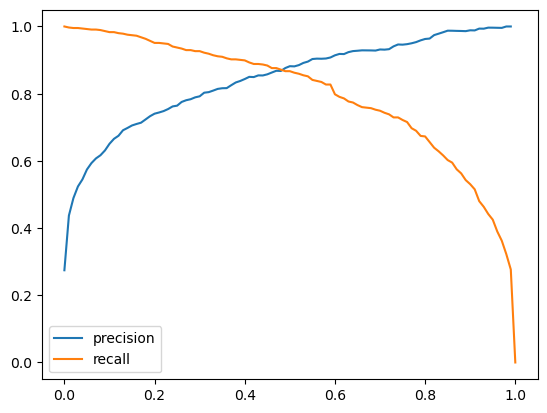

In [338]:
#@ INSPECTING THE CURVES:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

### Question 4: F1 score

In [339]:
#@ GETTING F1 SCORES:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

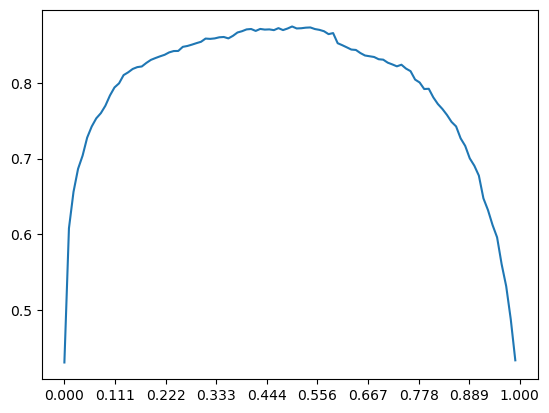

In [340]:
#@ INSPECTING F1 SCORE:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1,10))
plt.show()

In [341]:
df_scores[df_scores.f1==max(df_scores.f1)]

,threshold,tp,fp,fn,tn,p,r,f1
50,0.5,567,76,87,1653,0.881804,0.866972,0.874325


### Question 5: 5-Fold CV

In [342]:
# Preprocessing + training of model
def train(df_train, y_train, C=C):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [343]:
# Prediction of y values
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [344]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5,1.0,10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        # the k-fold split uses index to shuffle the data
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        # y values come from dataset
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
        
        # training and predicting
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        # AUC
        auc = roc_auc_score(y_val, y_pred>=0.5)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

C=0.01 0.986 +- 0.002
C=0.1 0.999 +- 0.001
C=0.5 0.999 +- 0.001
C=1.0 1.000 +- 0.001
C=10 0.999 +- 0.001
